# Tahu lah apa ini?

In [8]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import OneClassSVM

In [10]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
file_path = 'dataset/agriculture_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset for review
# data.head(),data.info(),data.describe()

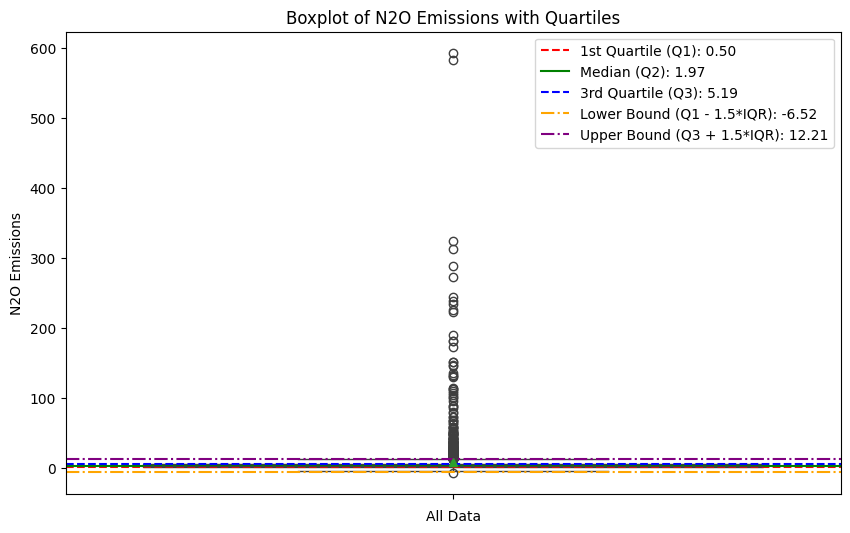

In [11]:


# Assuming your data is already loaded into a DataFrame called 'data'

# Generate a box plot for N2O with quartile divisions
plt.figure(figsize=(10, 6))

# Boxplot for N2O with quartiles
sns.boxplot(y='N2O', data=data, showmeans=True)
plt.title('Boxplot of N2O Emissions with Quartiles')
plt.ylabel('N2O Emissions')
plt.xlabel('All Data')

# Calculate quartiles and IQR
q1 = data['N2O'].quantile(0.25)
q2 = data['N2O'].median()
q3 = data['N2O'].quantile(0.75)
iqr = q3 - q1

# Adding horizontal lines for quartiles and IQR
plt.axhline(q1, color='r', linestyle='--', label=f'1st Quartile (Q1): {q1:.2f}')
plt.axhline(q2, color='g', linestyle='-', label=f'Median (Q2): {q2:.2f}')
plt.axhline(q3, color='b', linestyle='--', label=f'3rd Quartile (Q3): {q3:.2f}')
plt.axhline(q1 - 1.5 * iqr, color='orange', linestyle='-.', label=f'Lower Bound (Q1 - 1.5*IQR): {q1 - 1.5 * iqr:.2f}')
plt.axhline(q3 + 1.5 * iqr, color='purple', linestyle='-.', label=f'Upper Bound (Q3 + 1.5*IQR): {q3 + 1.5 * iqr:.2f}')

plt.legend()
plt.show()

Number of outliers per column:
N2O         32
N_rate       0
PP2         47
PP7         38
AirT         3
WFPS25cm     0
NH4         23
NO3         64
Clay         0
Sand         0
SOM          0
dtype: int64


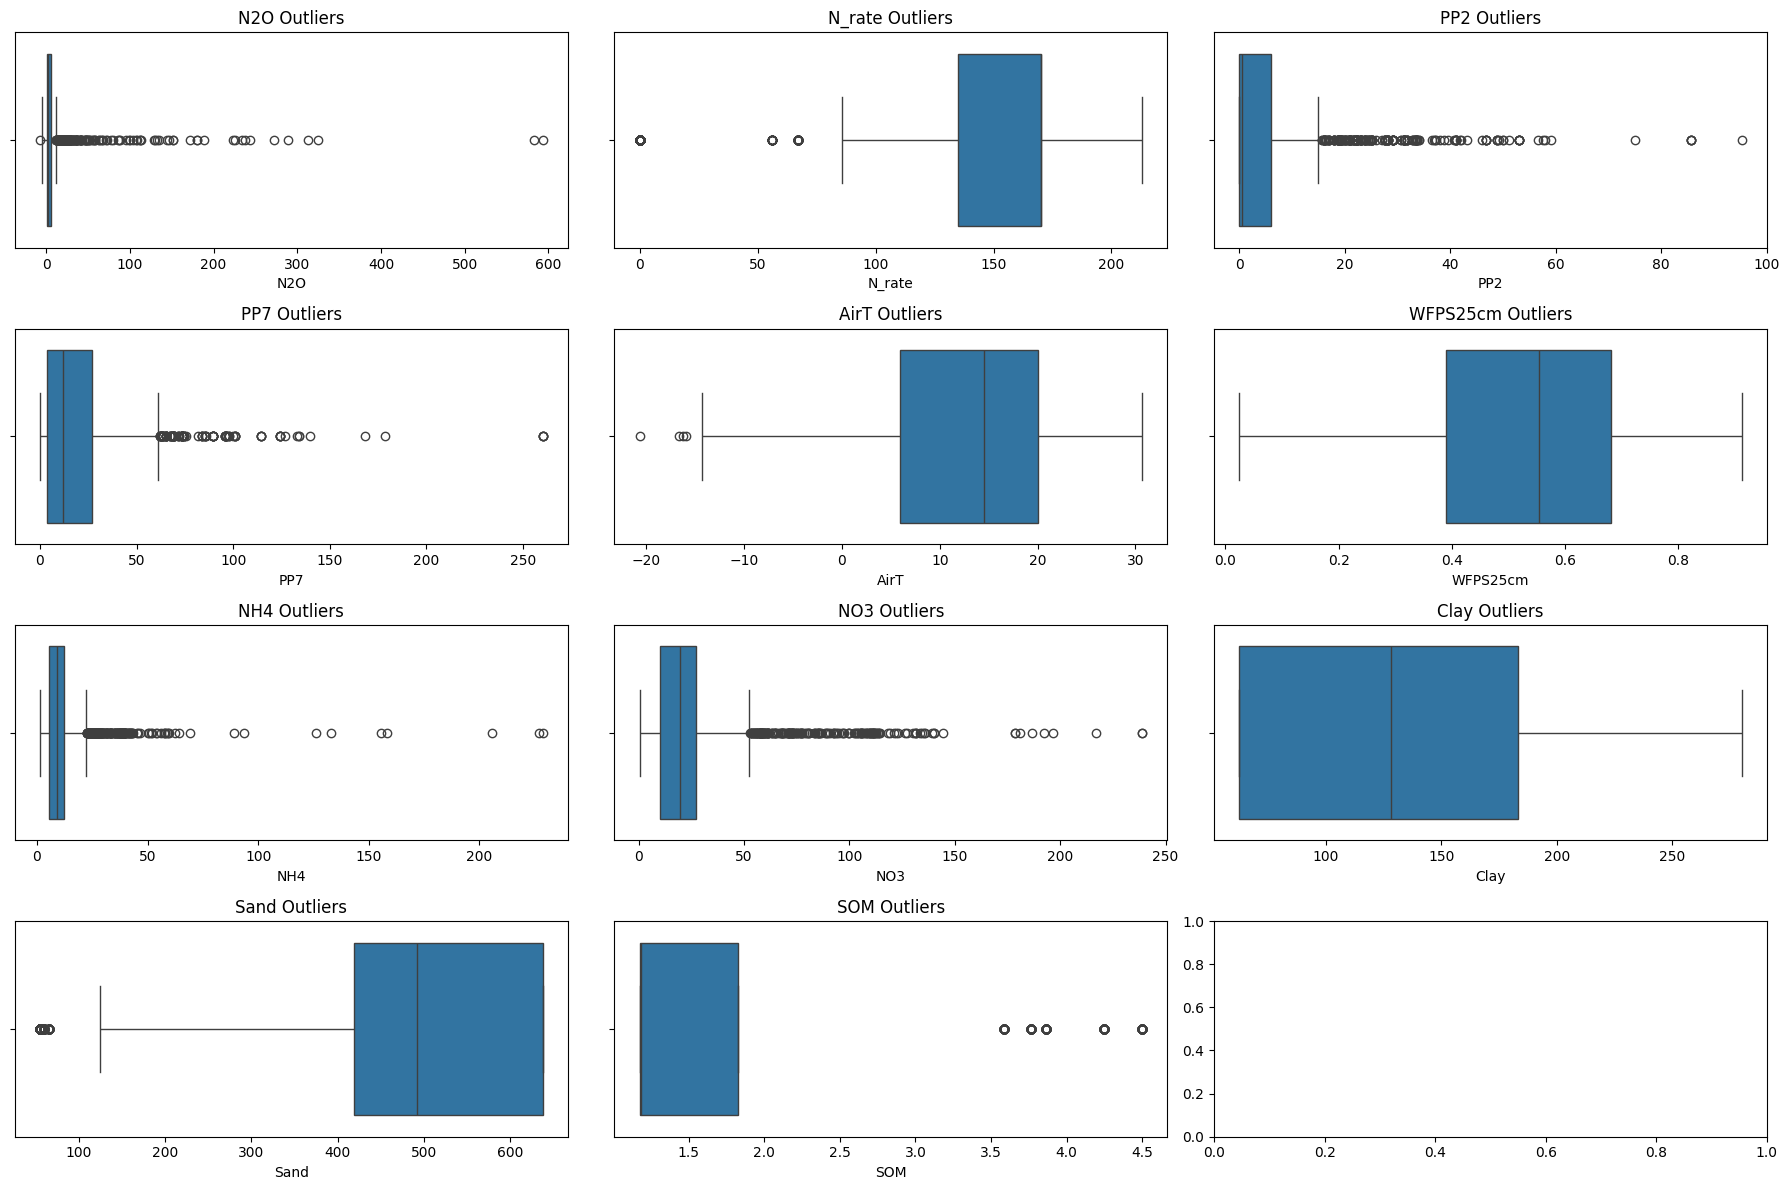

Number of multivariate outliers: 0


In [12]:
df=data
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# 1. Identify outliers using the Z-score method
z_scores = {}
for col in numerical_cols:
    z = np.abs((df[col] - df[col].mean()) / df[col].std())
    z_scores[col] = z

# Define the threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Create a boolean mask to identify outliers
outlier_mask = pd.DataFrame({col: z_scores[col] > threshold for col in numerical_cols})

# Print the number of outliers for each column
print("Number of outliers per column:")
print(outlier_mask.sum())

# 2. Visualize the outliers using boxplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Outliers")

plt.tight_layout()
plt.show()

# 3. Identify potential multivariate outliers using Mahalanobis distance
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

X = df[numerical_cols].values
cov_mat = np.cov(X.T)
inv_cov_mat = np.linalg.inv(cov_mat)

# Calculate the Mahalanobis distance for each data point
mahal_dists = [mahalanobis(x, X.mean(axis=0), inv_cov_mat) for x in X]

# Determine the outlier threshold based on the chi-square distribution
p = len(numerical_cols)
threshold = chi2.isf(0.01, df=p)

# Create a boolean mask to identify multivariate outliers
multivariate_outlier_mask = np.array(mahal_dists) > threshold

# Print the number of multivariate outliers
print(f"Number of multivariate outliers: {sum(multivariate_outlier_mask)}")

In [ ]:
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# Detect outliers using the IQR method
outlier_mask = pd.DataFrame()
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask[col] = outliers

# Print the number of outliers for each column
print("Number of outliers per column:")
print(outlier_mask.sum())

# Visualize the outliers using boxplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} Outliers")

plt.tight_layout()
plt.show()

## Malahobis Distance Outliers Detection

Number of outliers: 6


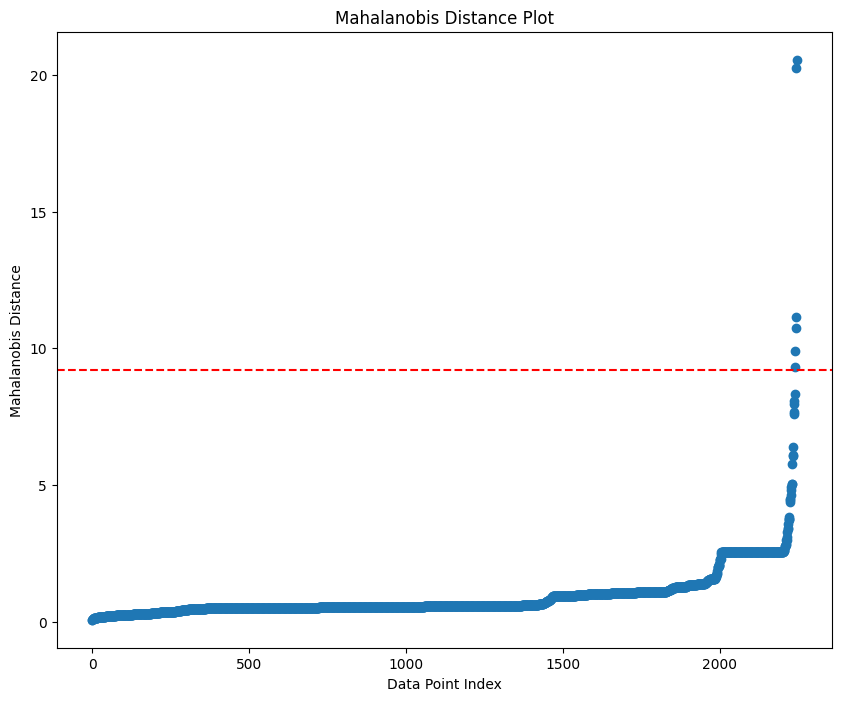

In [13]:
# Define the numerical columns
numerical_cols = ['N2O', 'N_rate'] #, 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']
# numerical_cols = ['N2O']

# Detect outliers using the Mahalanobis distance
X = df[numerical_cols].values
cov_mat = np.cov(X.T)
inv_cov_mat = np.linalg.inv(cov_mat)

# Calculate the Mahalanobis distance for each data point
mahal_dists = [mahalanobis(x, X.mean(axis=0), inv_cov_mat) for x in X]

# Determine the outlier threshold based on the chi-square distribution
p = len(numerical_cols)
threshold = chi2.isf(0.01, df=p)

# Create a boolean mask to identify outliers
outlier_mask = np.array(mahal_dists) > threshold

# Print the number of outliers
print(f"Number of outliers: {sum(outlier_mask)}")

# Visualize the outliers using a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(range(len(mahal_dists)), sorted(mahal_dists))
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Mahalanobis Distance Plot')
plt.xlabel('Data Point Index')
plt.ylabel('Mahalanobis Distance')
plt.show()

## Isolation Forest

In [ ]:
df=data
# Define the numerical columns
numerical_cols = ['N2O'] # 'N_rate', 'PP2', 'PP7', 'AirT', 'WFPS25cm', 'NH4', 'NO3', 'Clay', 'Sand', 'SOM']

# Handle missing values using the mean imputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df[numerical_cols])

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_scores = iso_forest.fit_predict(X)

# Create a boolean mask to identify outliers
outlier_mask = outlier_scores == -1

# Print the number of outliers
print(f"Number of outliers: {sum(outlier_mask)}")

# Visualize the outliers using a scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(range(len(outlier_scores)), sorted(outlier_scores), c=['g' if score == 1 else 'r' for score in outlier_scores])
plt.axhline(y=-1, color='r', linestyle='--')
plt.title('Isolation Forest Outlier Scores')
plt.xlabel('Data Point Index')
plt.ylabel('Outlier Score')
plt.show()

In [ ]:
# Create a boolean mask to identify outliers
outlier_mask = outlier_scores == -1

# Visualize the outliers using a scatter plot matrix
plt.figure(figsize=(12, 12))
num_cols = len(numerical_cols)
for i in range(num_cols):
    for j in range(num_cols):
        if i == j:
            # Plot the histogram for the diagonal subplots
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            df[numerical_cols[i]].plot(kind='hist', bins=20, title=numerical_cols[i])
        else:
            # Plot the scatter plot for the off-diagonal subplots
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            plt.scatter(df[numerical_cols[j]], df[numerical_cols[i]], c=['g' if outlier_scores[k] == 1 else 'r' for k in range(len(outlier_scores))], s=10, alpha=0.5)
            plt.xlabel(numerical_cols[j])
            plt.ylabel(numerical_cols[i])

plt.tight_layout()
plt.show()


In [ ]:
# Visualize the outliers using a scatter plot
plt.figure(figsize=(3, 2))
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        plt.subplot(3, 4, i * (len(numerical_cols)-1) + j - i + 1)
        plt.scatter(df[numerical_cols[j]], df[numerical_cols[i]], c=['g' if score == 1 else 'r' for score in outlier_scores], s=10, alpha=0.5)
        plt.xlabel(numerical_cols[j])
        plt.ylabel(numerical_cols[i])
        plt.title(f"{numerical_cols[i]} vs {numerical_cols[j]}")

plt.tight_layout()
plt.show()

## Z-score

In [ ]:
# Assuming you have a DataFrame called df containing the tabular data
n2o_column = df['N2O']

# Calculate the z-scores
z_scores = (n2o_column - n2o_column.mean()) / n2o_column.std()

# Define the z-score threshold for outliers
threshold_z_score = 3

# Detect outliers
outliers_z_score = n2o_column[abs(z_scores) > threshold_z_score]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_z_score.index, y=outliers_z_score, color='red', label='Outliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (z-score)')

# Show the plot
plt.legend()
plt.show()

## Tuckey Fences

In [ ]:
# Assuming you have a DataFrame called df containing the tabular data
n2o_column = df['N2O']

# Calculate the IQR
Q1 = n2o_column.quantile(0.25)
Q3 = n2o_column.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Detect outliers
outliers_tukey = n2o_column[(n2o_column < lower_fence) | (n2o_column > upper_fence)]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_tukey.index, y=outliers_tukey, color='red', label='Outliers')

# Highlight the data points within the fences using blue color
inliers_tukey = n2o_column[(n2o_column >= lower_fence) & (n2o_column <= upper_fence)]
sns.scatterplot(x=inliers_tukey.index, y=inliers_tukey, color='blue', label='Inliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (Tukey\'s fences)')

# Show the plot
plt.legend()
plt.show()

## LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Assuming you have a DataFrame called df containing the tabular data
# n2o_column = df['N2O']

# Reshape the data into a 2D array for LOF input
X = np.array(n2o_column).reshape(-1, 1)

# Create an instance of the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed

# Fit the LOF model and calculate LOF scores
lof_scores = lof.fit_predict(X)

# Identify outliers based on negative LOF scores
outliers_lof = n2o_column[lof_scores == -1]

# Create a scatter plot of the N2O column
sns.scatterplot(x=n2o_column.index, y=n2o_column, label='Data Points')

# Highlight the outliers using red color
sns.scatterplot(x=outliers_lof.index, y=outliers_lof, color='red', label='Outliers')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.title('Scatter Plot of N2O column with Outliers (LOF)')

# Show the plot
plt.legend()
plt.show()

In [ ]:
from scipy.stats import iqr
from scipy.spatial.distance import mahalanobis
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN, OPTICS


In [ ]:
df

In [ ]:
# Extract the N2O column
n2o_values = df['N2O']

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from DBSCAN
dbscan_outliers = np.where(dbscan.labels_ == -1)[0]

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics.fit(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from OPTICS
optics_outliers = np.where(optics.labels_ == -1)[0]

# Create pandas DataFrame tables for DBSCAN and OPTICS outlier results
dbscan_table = pd.DataFrame({'Data Point': df.index,
                             'N2O Value': n2o_values,
                             'DBSCAN Cluster Label': dbscan.labels_})
optics_table = pd.DataFrame({'Data Point': df.index,
                             'N2O Value': n2o_values,
                             'OPTICS Reachability Distance': optics.reachability_})

# Visualize DBSCAN outlier detection
plt.scatter(dbscan_table['Data Point'], dbscan_table['N2O Value'], c=dbscan_table['DBSCAN Cluster Label'], cmap='viridis')
plt.scatter(dbscan_outliers, dbscan_table.loc[dbscan_outliers, 'N2O Value'], c='red', label='DBSCAN Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by DBSCAN')
plt.legend()
plt.show()

# Visualize OPTICS outlier detection
plt.scatter(optics_table['Data Point'], optics_table['N2O Value'], c=optics_table['OPTICS Reachability Distance'], cmap='viridis')
plt.scatter(optics_outliers, optics_table.loc[optics_outliers, 'N2O Value'], c='red', label='OPTICS Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by OPTICS')
plt.legend()
plt.show()

# Print the DBSCAN outlier table
print("DBSCAN Outlier Table:")
print(dbscan_table[dbscan_table['DBSCAN Cluster Label'] == -1])

# Print the OPTICS outlier table
print("\nOPTICS Outlier Table:")
print(optics_table[optics_table['OPTICS Reachability Distance'] == np.inf])

In [ ]:
dbscan_table.head(), optics_table.head()

In [ ]:
# Extract the N2O column
n2o_values = df['N2O']

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
outlier_scores = lof.fit_predict(n2o_values.values.reshape(-1, 1))

# Get the outlier indices from LOF
outliers = df[outlier_scores == -1]

# Visualize LOF outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='LOF Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by LOF')
plt.legend()
plt.show()

# Print the LOF outlier table
print("LOF Outlier Table:")
print(outliers)

In [ ]:
from pyod.models.cblof import CBLOF
# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
outlier_scores = cblof.fit_predict(n2o_values)

# Get the outlier indices from CBLOF
outliers = df[outlier_scores == 1]

# Visualize CBLOF outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='CBLOF Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by CBLOF')
plt.legend()
plt.show()

# Print the CBLOF outlier table
print("CBLOF Outlier Table:")
print(outliers)

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
outlier_scores = robust_cov.fit_predict(n2o_values)

# Get the outlier indices from the Robust Covariance Estimation
outliers = df[outlier_scores == -1]

# Visualize the Robust Covariance Estimation outlier detection
plt.scatter(df.index, n2o_values, c=outlier_scores, cmap='viridis')
plt.scatter(outliers.index, outliers['N2O'], c='red', label='Outliers')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('N2O Outliers Detected by Robust Covariance Estimation')
plt.legend()
plt.show()

# Print the Robust Covariance Estimation outlier table
print("Robust Covariance Estimation Outlier Table:")
print(outliers)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.cblof import CBLOF
from sklearn.covariance import EllipticEnvelope

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_outliers = dbscan.fit_predict(n2o_values)

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics_outliers = optics.fit_predict(n2o_values)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
lof_outliers = lof.fit_predict(n2o_values)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
cblof_outliers = cblof.fit_predict(n2o_values)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
robust_cov_outliers = robust_cov.fit_predict(n2o_values)

# Visualize outlier detection results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.scatter(df.index, n2o_values, c=dbscan_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('DBSCAN Outliers')

plt.subplot(2, 3, 2)
plt.scatter(df.index, n2o_values, c=optics_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('OPTICS Outliers')

plt.subplot(2, 3, 3)
plt.scatter(df.index, n2o_values, c=lof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('LOF Outliers')

plt.subplot(2, 3, 4)
plt.scatter(df.index, n2o_values, c=cblof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('CBLOF Outliers')

plt.subplot(2, 3, 5)
plt.scatter(df.index, n2o_values, c=robust_cov_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Robust Covariance Estimation Outliers')

plt.tight_layout()
plt.show()

# Print the outlier tables
print("DBSCAN Outlier Table:")
print(df[dbscan_outliers == -1])

print("\nOPTICS Outlier Table:")
print(df[optics_outliers == -1])

print("\nLOF Outlier Table:")
print(df[lof_outliers == -1])

print("\nCBLOF Outlier Table:")
print(df[cblof_outliers == -1])

print("\nRobust Covariance Estimation Outlier Table:")
print(df[robust_cov_outliers == -1])

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.cblof import CBLOF
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual filename

# Extract the N2O column
n2o_values = df['N2O'].values.reshape(-1, 1)

# Apply DBSCAN clustering to detect outliers
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_outliers = dbscan.fit_predict(n2o_values)

# Apply OPTICS clustering to detect outliers
optics = OPTICS(eps=0.5, min_samples=5)
optics_outliers = optics.fit_predict(n2o_values)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
lof_outliers = lof.fit_predict(n2o_values)

# Apply CBLOF for outlier detection
cblof = CBLOF(contamination=0.05, check_estimator=False, random_state=0)
cblof_outliers = cblof.fit_predict(n2o_values)

# Apply Robust Covariance Estimation for outlier detection
robust_cov = EllipticEnvelope(contamination=0.05)
robust_cov_outliers = robust_cov.fit_predict(n2o_values)

# Apply Isolation Forest for outlier detection
isolation_forest = IsolationForest(contamination=0.05, random_state=0)
isolation_forest_outliers = isolation_forest.fit_predict(n2o_values)

# Apply One-Class SVM for outlier detection
one_class_svm = OneClassSVM(nu=0.05)
one_class_svm_outliers = one_class_svm.fit_predict(n2o_values)

# Visualize outlier detection results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(df.index, n2o_values, c=dbscan_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('DBSCAN Outliers')

plt.subplot(2, 3, 2)
plt.scatter(df.index, n2o_values, c=optics_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('OPTICS Outliers')

plt.subplot(2, 3, 3)
plt.scatter(df.index, n2o_values, c=lof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('LOF Outliers')

plt.subplot(2, 3, 4)
plt.scatter(df.index, n2o_values, c=cblof_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('CBLOF Outliers')

plt.subplot(2, 3, 5)
plt.scatter(df.index, n2o_values, c=robust_cov_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Robust Covariance Estimation Outliers')

plt.subplot(2, 3, 6)
plt.scatter(df.index, n2o_values, c=isolation_forest_outliers, cmap='viridis')
plt.xlabel('Data Points')
plt.ylabel('N2O Values')
plt.title('Isolation Forest Outliers')

plt.tight_layout()
plt.show()

# Print the outlier tables
print("DBSCAN Outlier Table:")
print(df[dbscan_outliers == -1])

print("\nOPTICS Outlier Table:")
print(df[optics_outliers == -1])

print("\nLOF Outlier Table:")
print(df[lof_outliers == -1])

print("\nCBLOF Outlier Table:")
print(df[cblof_outliers == -1])

print("\nRobust Covariance Estimation Outlier Table:")
print(df[robust_cov_outliers == -1])

print("\nIsolation Forest Outlier Table:")
print(df[isolation_forest_outliers == -1])

print("\nOneClass SVM Outlier Table:")
print(df[one_class_svm_outliers == -1])

In [ ]:
df

In [ ]:
# Extract the N2O column
n2o_column = data['N2O']

# Create a box plot of the N2O column
plt.boxplot(n2o_column)
plt.xlabel('N2O')
plt.ylabel('Values')
plt.title('Box Plot of N2O')
plt.show()

# Calculate the upper and lower fences
q1 = n2o_column.quantile(0.25)
q3 = n2o_column.quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

# Identify potential outliers based on the box plot and maximum/minimum values
outliers = n2o_column[(n2o_column < lower_fence) | (n2o_column > upper_fence) | (n2o_column > n2o_column.max()) | (n2o_column < n2o_column.min())]

print("Potential outliers:")
print(outliers)

In [ ]:

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import DBSCAN


In [ ]:

# Load the data
# data = pd.read_csv('path_to_your_csv_file.csv')
n2o_data = data[['N2O']]

# Initialize the outlier detection models
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
lof = LocalOutlierFactor(contamination=0.1)
one_class_svm = OneClassSVM(nu=0.1)
elliptic_envelope = EllipticEnvelope(contamination=0.1)
hbos = HBOS()
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the models and predict outliers
n2o_data['IF_Outlier'] = isolation_forest.fit_predict(n2o_data)
n2o_data['LOF_Outlier'] = lof.fit_predict(n2o_data)
n2o_data['OCSVM_Outlier'] = one_class_svm.fit_predict(n2o_data)
n2o_data['Elliptic_Outlier'] = elliptic_envelope.fit_predict(n2o_data)
n2o_data['HBOS_Outlier'] = hbos.fit_predict(n2o_data)
n2o_data['DBSCAN_Outlier'] = dbscan.fit_predict(n2o_data)

# Calculate Mahalanobis Distance and detect outliers
cov_matrix = n2o_data[['N2O']].cov().to_numpy()
mean_distr = n2o_data[['N2O']].mean().to_numpy()
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, mean, inv_cov_matrix):
    return mahalanobis(x, mean, inv_cov_matrix)

n2o_data['Mahalanobis_Distance'] = n2o_data[['N2O']].apply(lambda x: mahalanobis_distance(x, mean_distr, inv_cov_matrix), axis=1)
threshold = n2o_data['Mahalanobis_Distance'].quantile(0.95)
n2o_data['Mahalanobis_Outlier'] = (n2o_data['Mahalanobis_Distance'] > threshold).astype(int)

# Save the results to a CSV file
n2o_data.to_csv('n2o_outlier_detection_results.csv', index=False)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot the original data with outliers highlighted
plt.scatter(n2o_data.index, n2o_data['N2O'], color='blue', label='Data')
plt.scatter(n2o_data.index[n2o_data['IF_Outlier'] == -1], n2o_data['N2O'][n2o_data['IF_Outlier'] == -1], color='red', label='Isolation Forest Outliers')
plt.scatter(n2o_data.index[n2o_data['LOF_Outlier'] == -1], n2o_data['N2O'][n2o_data['LOF_Outlier'] == -1], color='green', label='LOF Outliers')
plt.scatter(n2o_data.index[n2o_data['OCSVM_Outlier'] == -1], n2o_data['N2O'][n2o_data['OCSVM_Outlier'] == -1], color='orange', label='One-Class SVM Outliers')
plt.scatter(n2o_data.index[n2o_data['Elliptic_Outlier'] == -1], n2o_data['N2O'][n2o_data['Elliptic_Outlier'] == -1], color='purple', label='Elliptic Envelope Outliers')
plt.scatter(n2o_data.index[n2o_data['HBOS_Outlier'] == -1], n2o_data['N2O'][n2o_data['HBOS_Outlier'] == -1], color='brown', label='HBOS Outliers')
plt.scatter(n2o_data.index[n2o_data['DBSCAN_Outlier'] == -1], n2o_data['N2O'][n2o_data['DBSCAN_Outlier'] == -1], color='pink', label='DBSCAN Outliers')
plt.scatter(n2o_data.index[n2o_data['Mahalanobis_Outlier'] == 1], n2o_data['N2O'][n2o_data['Mahalanobis_Outlier'] == 1], color='black', label='Mahalanobis Outliers')

# Adding labels and title
plt.title('N2O Outlier Detection Results')
plt.xlabel('Index')
plt.ylabel('N2O Values')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the data
# data = pd.read_csv('path_to_your_csv_file.csv')
# file_path = 'dataset/agriculture_dataset.csv'
# data = pd.read_csv(file_path)
 = data[['N2O']]

# Initialize the outlier detection models
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
lof = LocalOutlierFactor(contamination=0.1)
one_class_svm = OneClassSVM(nu=0.1)
elliptic_envelope = EllipticEnvelope(contamination=0.1)
hbos = HBOS()
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the models and predict outliers
['IF_Outlier'] = isolation_forest.fit_predict()
['LOF_Outlier'] = lof.fit_predict()
['OCSVM_Outlier'] = one_class_svm.fit_predict()
['Elliptic_Outlier'] = elliptic_envelope.fit_predict()
['HBOS_Outlier'] = hbos.fit_predict()
['DBSCAN_Outlier'] = dbscan.fit_predict()

# Calculate Mahalanobis Distance and detect outliers
cov_matrix = [['N2O']].cov().to_numpy()
mean_distr = [['N2O']].mean().to_numpy()
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, mean, inv_cov_matrix):
    return mahalanobis(x, mean, inv_cov_matrix)

['Mahalanobis_Distance'] = [['N2O']].apply(lambda x: mahalanobis_distance(x, mean_distr, inv_cov_matrix), axis=1)
threshold = ['Mahalanobis_Distance'].quantile(0.95)
['Mahalanobis_Outlier'] = (['Mahalanobis_Distance'] > threshold).astype(int)

data


data = pd.concat([data, [['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier', 'Ground_Truth']]], axis=1)
data.to_csv('09_05_1_AgricultureOutliersResult_30052024.csv', index=False)


In [ ]:

# Generate synthetic ground truth labels for evaluation purposes
# Here, we'll assume that '1' indicates inliers and '-1' indicates outliers in the original data
# This is just for the sake of comparison; in a real scenario, ground truth labels would be known
# Creating a synthetic ground truth based on majority voting of outliers
n2o_data['Ground_Truth'] = n2o_data.apply(lambda row: 1 if row[['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']].mode()[0] == 1 else -1, axis=1)

# Calculate precision, recall, and F1-score for each method
evaluation_metrics = {}

methods = ['IF_Outlier', 'LOF_Outlier', 'OCSVM_Outlier', 'Elliptic_Outlier', 'HBOS_Outlier', 'DBSCAN_Outlier', 'Mahalanobis_Outlier']

for method in methods:
    precision = precision_score(n2o_data['Ground_Truth'], n2o_data[method], pos_label=-1)
    recall = recall_score(n2o_data['Ground_Truth'], n2o_data[method], pos_label=-1)
    f1 = f1_score(n2o_data['Ground_Truth'], n2o_data[method], pos_label=-1)
    evaluation_metrics[method] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Convert the evaluation metrics to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics).T

# Save the evaluation results to a CSV file
evaluation_df.to_csv('n2o_outlier_detection_evaluation.csv', index=True)

# Display the evaluation results
print(evaluation_df)